# Rede Neural Para Previsão de Falhas em Rolamentos de Aerogeradores Usando Pytorch

Este notebook apresenta o modelo de rede neural apresentado por Shcleichtingen e Santos (2011) para a previsão de falhas em rolamentos de aerogeradores, como parte do projeto de mestrado. Aqui, será usado a biblioteca Pytorch para a construção da rede neural.

In [55]:
# Definindo Bibliotecas
import numpy as np
import pandas as pd
import torch
import helper

%matplotlib inline

import seaborn as sb
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [56]:
# Importando dados pro Dataset
df = pd.read_csv('T1.csv')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


### Fase 1: Pré-processamento

Esse modelo de teste será construído de forma a modelar a potência de saída de acordo com a velocidade e direção do vento. Em outras palavras, a rede terá como entradas as variáveis Wind Direction (°) e Wind Speed (m/s), e como saída LV ActivePower (kW).

Dessa forma, a variável Theoretical_power_curve será desconsiderada.

In [57]:
df = df.drop('Theoretical_Power_Curve (KWh)', axis = 1)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,259.994904
1,01 01 2018 00:10,453.769196,5.672167,268.641113
2,01 01 2018 00:20,306.376587,5.216037,272.564789
3,01 01 2018 00:30,419.645905,5.659674,271.258087
4,01 01 2018 00:40,380.650696,5.577941,265.674286


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
Date/Time              50530 non-null object
LV ActivePower (kW)    50530 non-null float64
Wind Speed (m/s)       50530 non-null float64
Wind Direction (°)     50530 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


De acordo com a informação acima, a variável Date/time está no time object. Deve-se então transformá-la para o tipo date-time.

In [59]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
Date/Time              50530 non-null datetime64[ns]
LV ActivePower (kW)    50530 non-null float64
Wind Speed (m/s)       50530 non-null float64
Wind Direction (°)     50530 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


Removendo NaN

In [60]:
df.dropna(axis = 0, how = 'any')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
Date/Time              50530 non-null datetime64[ns]
LV ActivePower (kW)    50530 non-null float64
Wind Speed (m/s)       50530 non-null float64
Wind Direction (°)     50530 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


Removendo valores duplicados

In [61]:
sum(df.duplicated())

0

In [62]:
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50530 entries, 0 to 50529
Data columns (total 4 columns):
Date/Time              50530 non-null datetime64[ns]
LV ActivePower (kW)    50530 non-null float64
Wind Speed (m/s)       50530 non-null float64
Wind Direction (°)     50530 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 MB


Eliminando numero menores que zero

In [63]:
for cols in df.columns.tolist()[1:]:
    df = df.loc[df[cols] > 0]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
count,39690.000000,39690.000000,39690.000000
mean,1664.832940,8.769919,115.538096
std,1264.283374,3.773626,86.275122
min,0.000200,1.208934,0.015678
25%,481.716141,5.911983,49.043281
50%,1394.217957,8.114672,70.242912
75%,2908.383301,11.099932,197.156948
max,3618.732910,25.206011,359.997589


##### Remoção de outliers

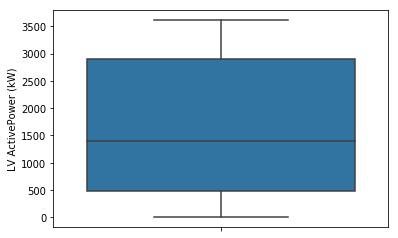

In [64]:
sb.boxplot(data = df, y= 'LV ActivePower (kW)')

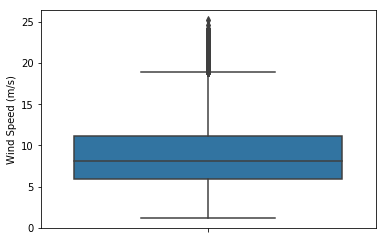

In [65]:
sb.boxplot(data = df, y= 'Wind Speed (m/s)')

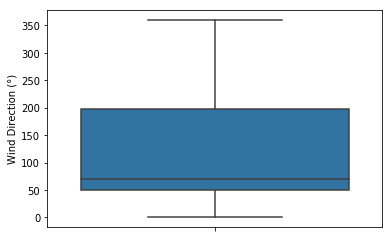

In [66]:
sb.boxplot(data = df, y= 'Wind Direction (°)')

Nota-se, pelos gráficos acima, que a variável Wind Speed aprensenta alguns outliers que devem ser removidos do Dataset. Dessa forma, eles serão removidos utilizando a seguinte formula: $$ Q3 + 1.5*AIQ < Outlier < Q1 - 1.5*AIQ $$ aonde AIQ significa amplitude interquartil

In [67]:
WS_Q1 = df['Wind Speed (m/s)'].quantile(0.25)
WS_Q3 = df['Wind Speed (m/s)'].quantile(0.75)

WS_IQR = WS_Q3 - WS_Q1

df = df.loc[df['Wind Speed (m/s)'] > WS_Q1 - 1.5*WS_IQR]
df = df.loc[df['Wind Speed (m/s)'] < WS_Q3 + 1.5*WS_IQR]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
count,39076.000000,39076.000000,39076.000000
mean,1635.024724,8.590286,114.268271
std,1251.304296,3.515108,86.335212
min,0.000200,1.208934,0.015678
25%,471.007072,5.879802,48.589694
50%,1357.751038,8.039958,69.606670
75%,2832.098755,10.941510,196.758205
max,3618.732910,18.880831,359.997589


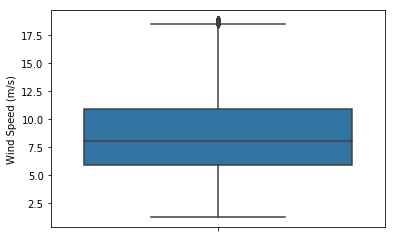

In [68]:
sb.boxplot(data = df, y= 'Wind Speed (m/s)')

In [69]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,265.674286


##### Separando o dataset em treinamento, teste e validação

Os dados serão separados da seguinte forma: 80% para treinamento, 10% para teste e 10% para validação

In [70]:
train_lengh = int(len(df)*0.8)
train_data = df[0:train_lengh]

test_lengh = train_lengh + int(len(df)*0.1)
test_data = df[train_lengh:test_lengh]

validation_data = df[test_lengh:]

In [71]:
train_data.info()
test_data.info()
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31260 entries, 0 to 40678
Data columns (total 4 columns):
Date/Time              31260 non-null datetime64[ns]
LV ActivePower (kW)    31260 non-null float64
Wind Speed (m/s)       31260 non-null float64
Wind Direction (°)     31260 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3907 entries, 40679 to 44867
Data columns (total 4 columns):
Date/Time              3907 non-null datetime64[ns]
LV ActivePower (kW)    3907 non-null float64
Wind Speed (m/s)       3907 non-null float64
Wind Direction (°)     3907 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 152.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3909 entries, 44868 to 50529
Data columns (total 4 columns):
Date/Time              3909 non-null datetime64[ns]
LV ActivePower (kW)    3909 non-null float64
Wind Speed (m/s)       3909 non-null float64
Wind Direction (°)     3909 no

##### Escalonamento

In [72]:
#Normalização do banco de dados de treinamento segundo o artigo

dfn = train_data.copy()

i = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']
for j in i:
    a = dfn[j].max()
    b = dfn[j].min()
    dfn[j] = (dfn[j]-b)/(a-b)
    
dfn.describe()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
count,31260.000000,31260.000000,31260.000000
mean,0.437742,0.397220,0.308632
std,0.345438,0.201435,0.238969
min,0.000000,0.000000,0.000000
25%,0.117371,0.239359,0.132403
50%,0.354227,0.366290,0.186959
75%,0.762294,0.534926,0.543276
max,1.000000,1.000000,1.000000


In [73]:
# Normalização dos dados de teste segundo o artigo

dfnt = test_data.copy()

i = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']
for j in i:
    a = dfnt[j].max()
    b = dfnt[j].min()
    dfnt[j] = (dfnt[j]-b)/(a-b)
    
dfnt.describe()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
count,3907.000000,3907.000000,3907.000000
mean,0.458339,0.382929,0.335191
std,0.299433,0.172315,0.231567
min,0.000000,0.000000,0.000000
25%,0.202529,0.262395,0.167496
50%,0.386320,0.352292,0.207486
75%,0.712191,0.486754,0.550442
max,1.000000,1.000000,1.000000


In [74]:
#Normalização do banco de dados de treinamento 

#dfn = train_data.copy()

#i = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']
#for j in i:
#    a = dfn[j].mean()
#    b = dfn[j].std()
#    dfn[j] = (dfn[j]-a)/b
    
#dfn.describe()

In [75]:
# Normalização dos dados de teste

#dfnt = test_data.copy()

#i = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']
#for j in i:
#    a = dfnt[j].mean()
#    b = dfnt[j].std()
#    dfnt[j] = (dfnt[j]-a)/b
    
#dfnt.describe()

Definindo features e targets

In [76]:
features_train, targets_train = dfn[['Wind Speed (m/s)',"Wind Direction (°)"]], dfn['LV ActivePower (kW)']
features_test, targets_test = dfnt[['Wind Speed (m/s)',"Wind Direction (°)"]], dfnt['LV ActivePower (kW)']

Transformando dados de treinamento em tensores

In [77]:
features_train = torch.from_numpy(np.array(features_train)).double().requires_grad_(True)
targets_train = torch.from_numpy(np.array(targets_train)).double().requires_grad_(True)

#features_train.requires_grad_(True)
#targets_train.requires_grad_(True)

In [78]:
print(features_train.size())
print(targets_train.size())

torch.Size([31260, 2])
torch.Size([31260])


### Fase 2: Construção da rede neural

O modelo proposto em Schlechtingen e Santos (2011) é uma rede neural do tipo feedforward com 5 neurons na hidden layer, como mostrado na figura a seguir:
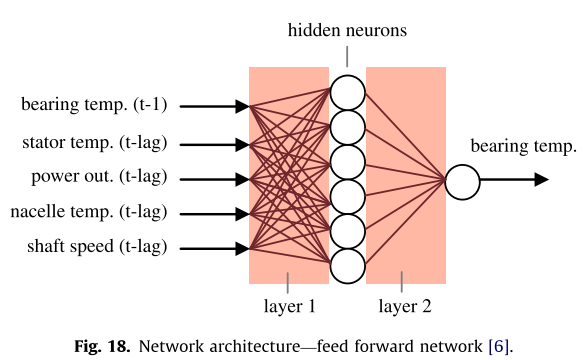

Os sinais de input, para o caso específico dessa simulação, serão Velocidade do Vento (Wind Speed) e Direção (Wind Direction), e a saída será a Potência de Saída (Power Output).

A função de ativação será a função Sigmoide.

Método de treinamento: Gradiente descendente com momento.

Pesos iniciados aleatóriamente.





In [79]:
from torch import nn
import torch.nn.functional as F

In [80]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

model = Network().double()
model

Network(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

Incializando pesos e bias

In [81]:
model.fc1.weight.data.normal_(std = 0.01)
model.fc2.weight.data.normal_(std = 0.01)

tensor([[-0.0002,  0.0012,  0.0165, -0.0026, -0.0048]], dtype=torch.float64)

In [83]:
#### TESTE

ps = model.forward(features_train[0])

ps

tensor([0.4244], dtype=torch.float64, grad_fn=<SigmoidBackward>)

Jeito mais simples de construção do modelo em pytorch, nomeando a rede neural...

In [84]:
from collections import OrderedDict

input_size = 2
hidden_size = 5
output_size = 1

model = nn.Sequential(OrderedDict([
                    ('fc1', nn.Linear(input_size, hidden_size)),
                    ('sig1', nn.Sigmoid()),
                    ('fc2', nn.Linear(hidden_size, output_size)),
                    ('sig2', nn.Sigmoid())
]))

model = model.double()

model

Sequential(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (sig1): Sigmoid()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (sig2): Sigmoid()
)

In [86]:
### TESTE

ps = model.forward(features_train[0])

ps


tensor([0.3964], dtype=torch.float64, grad_fn=<SigmoidBackward>)

In [87]:
print(model.fc1.weight)
print(model.fc2.weight)

Parameter containing:
tensor([[-0.7004,  0.6030],
        [ 0.1031, -0.6825],
        [-0.4219,  0.2672],
        [ 0.1278,  0.2138],
        [ 0.0372,  0.5850]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[ 0.2331,  0.4145, -0.1363, -0.3303, -0.3681]], dtype=torch.float64,
       requires_grad=True)


### Fase 3: Treinamento da rede neural

A rede neural será treinada através de Gradient Descent, ou gradiente descendente.

In [88]:
import time

from torch import optim

In [89]:
#criterion = nn.CrossEntropyLoss() #Função erro # não funciona

def criterion(output, targets):  # acredito que esteja errado
    return targets - output

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)    #atualiza os pesos na rede 
                                                                        #SGD = stochastic gradiente descent

Treinamento

In [90]:
epochs = 1
print_every = 40
steps = 0

for i in range(epochs):
    running_loss = 0
    for i in range(len(features_train)):
        steps += 1
    
        optimizer.zero_grad()
        
        output = model.forward(features_train[i])
        loss = criterion(output, targets_train[i])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Loss: {:4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 40/1... Loss: -0.339235
Epoch: 80/1... Loss: -0.745059
Epoch: 120/1... Loss: -0.381007
Epoch: 160/1... Loss: -0.009859
Epoch: 200/1... Loss: -0.043121
Epoch: 240/1... Loss: -0.069973
Epoch: 280/1... Loss: -0.142761
Epoch: 320/1... Loss: -0.607099
Epoch: 360/1... Loss: -0.700470
Epoch: 400/1... Loss: -0.824548
Epoch: 440/1... Loss: -0.613093
Epoch: 480/1... Loss: -0.644482
Epoch: 520/1... Loss: -0.782699
Epoch: 560/1... Loss: -0.829279
Epoch: 600/1... Loss: -0.930193
Epoch: 640/1... Loss: -0.195085
Epoch: 680/1... Loss: -0.057780
Epoch: 720/1... Loss: -0.151767
Epoch: 760/1... Loss: -0.039040
Epoch: 800/1... Loss: -0.467277
Epoch: 840/1... Loss: -0.871028
Epoch: 880/1... Loss: -0.863641
Epoch: 920/1... Loss: -0.865006
Epoch: 960/1... Loss: -0.928989
Epoch: 1000/1... Loss: -0.774001
Epoch: 1040/1... Loss: -0.845198
Epoch: 1080/1... Loss: -0.811024
Epoch: 1120/1... Loss: -0.822812
Epoch: 1160/1... Loss: -0.579798
Epoch: 1200/1... Loss: -0.561138
Epoch: 1240/1... Loss: -0.944367
Epo

Epoch: 10000/1... Loss: -0.242399
Epoch: 10040/1... Loss: -0.187256
Epoch: 10080/1... Loss: -0.221553
Epoch: 10120/1... Loss: -0.886415
Epoch: 10160/1... Loss: -0.946192
Epoch: 10200/1... Loss: -0.916590
Epoch: 10240/1... Loss: -0.855381
Epoch: 10280/1... Loss: -0.913963
Epoch: 10320/1... Loss: -0.781770
Epoch: 10360/1... Loss: -0.818370
Epoch: 10400/1... Loss: -0.303549
Epoch: 10440/1... Loss: -0.004114
Epoch: 10480/1... Loss: -0.367556
Epoch: 10520/1... Loss: -0.190283
Epoch: 10560/1... Loss: -0.574287
Epoch: 10600/1... Loss: -0.621331
Epoch: 10640/1... Loss: -0.169140
Epoch: 10680/1... Loss: -0.313108
Epoch: 10720/1... Loss: -0.597076
Epoch: 10760/1... Loss: -0.676682
Epoch: 10800/1... Loss: -0.829237
Epoch: 10840/1... Loss: -0.936126
Epoch: 10880/1... Loss: -0.925612
Epoch: 10920/1... Loss: -0.855718
Epoch: 10960/1... Loss: -0.902387
Epoch: 11000/1... Loss: -0.962430
Epoch: 11040/1... Loss: -0.904189
Epoch: 11080/1... Loss: -0.894532
Epoch: 11120/1... Loss: -0.863890
Epoch: 11160/1

Epoch: 19600/1... Loss: -0.530395
Epoch: 19640/1... Loss: -0.333835
Epoch: 19680/1... Loss: -0.417078
Epoch: 19720/1... Loss: -0.587825
Epoch: 19760/1... Loss: -0.578547
Epoch: 19800/1... Loss: -0.674360
Epoch: 19840/1... Loss: -0.632623
Epoch: 19880/1... Loss: -0.612557
Epoch: 19920/1... Loss: -0.566308
Epoch: 19960/1... Loss: -0.826591
Epoch: 20000/1... Loss: -0.870222
Epoch: 20040/1... Loss: -0.632741
Epoch: 20080/1... Loss: -0.732620
Epoch: 20120/1... Loss: -0.922934
Epoch: 20160/1... Loss: -0.786219
Epoch: 20200/1... Loss: -0.918076
Epoch: 20240/1... Loss: -0.976281
Epoch: 20280/1... Loss: -0.970541
Epoch: 20320/1... Loss: -0.899494
Epoch: 20360/1... Loss: -0.926741
Epoch: 20400/1... Loss: -0.904206
Epoch: 20440/1... Loss: -0.900785
Epoch: 20480/1... Loss: -0.898641
Epoch: 20520/1... Loss: -0.834725
Epoch: 20560/1... Loss: -0.821096
Epoch: 20600/1... Loss: -0.954477
Epoch: 20640/1... Loss: -0.880295
Epoch: 20680/1... Loss: -0.958056
Epoch: 20720/1... Loss: -0.934126
Epoch: 20760/1

Epoch: 29200/1... Loss: -0.767185
Epoch: 29240/1... Loss: -0.924329
Epoch: 29280/1... Loss: -0.550885
Epoch: 29320/1... Loss: -0.080280
Epoch: 29360/1... Loss: -0.154161
Epoch: 29400/1... Loss: -0.084813
Epoch: 29440/1... Loss: -0.020377
Epoch: 29480/1... Loss: -0.244048
Epoch: 29520/1... Loss: -0.726403
Epoch: 29560/1... Loss: -0.336061
Epoch: 29600/1... Loss: -0.916864
Epoch: 29640/1... Loss: -0.950171
Epoch: 29680/1... Loss: -0.887528
Epoch: 29720/1... Loss: -0.928161
Epoch: 29760/1... Loss: -0.880627
Epoch: 29800/1... Loss: -0.806518
Epoch: 29840/1... Loss: -0.167221
Epoch: 29880/1... Loss: -0.193496
Epoch: 29920/1... Loss: -0.317905
Epoch: 29960/1... Loss: -0.090546
Epoch: 30000/1... Loss: -0.237243
Epoch: 30040/1... Loss: -0.297488
Epoch: 30080/1... Loss: -0.217832
Epoch: 30120/1... Loss: -0.319141
Epoch: 30160/1... Loss: -0.614835
Epoch: 30200/1... Loss: -0.723261
Epoch: 30240/1... Loss: -0.736681
Epoch: 30280/1... Loss: -0.244526
Epoch: 30320/1... Loss: -0.281887
Epoch: 30360/1

In [51]:
print(model.fc1.weight)

Parameter containing:
tensor([[ 8.5933,  1.6296],
        [-4.3750, -0.6309],
        [-6.6692, -0.8113],
        [-4.7476, -0.6487],
        [-1.9805, -0.1126]], dtype=torch.float64, requires_grad=True)


In [52]:
print(model.fc2.weight)

Parameter containing:
tensor([[ 7.0113, -2.2968, -4.2508, -2.5754, -0.7100]], dtype=torch.float64,
       requires_grad=True)


Com a rede treinada, podemos checar as previsões com o banco de dados de treinamento

In [45]:
# transdormanfo o banco de dados de teste em tensores

features_test = torch.from_numpy(np.array(features_test)).double()
targets_test = torch.from_numpy(np.array(targets_test)).double()

In [46]:
test_error = torch.rand((len(features_test), 1))

for i in range(len(features_test)):
    
    ps = model.forward(features_test[i])
    test_error[0] = targets_test[i] - ps

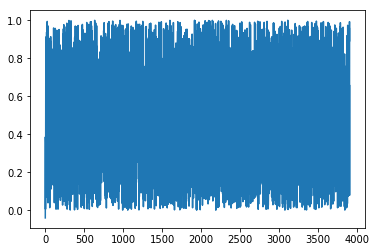

In [47]:
x = np.arange(1, len(features_test)+1, 1)
y = test_error.detach().numpy()

plt.plot(x, y) 

Falta: 

- Fazer o modelo diminuir o erro gradativamente (funcionar).
    - Implementar a função erro adequada.
    
- Definir métricas de avaliação.

- Transformar as previsões em escala real.

- Elaborar gráfico de controle.
